In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [6]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(17248, 31)
(17248, 4)


# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where RL swings
idxs = np.where(X_footsteps_accelerations_absolute[:, -1] == 1)[0]
X_footsteps_accelerations_absolute_RL_swing = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_RL_swing = Y_footsteps_accelerations_absolute[idxs]

## Predict RL foot -> x

In [9]:
X_footsteps_accelerations_absolute_RL_swing[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.09097511,  0.01569571,  0.03546102, -0.07442539,
        0.25578701,  0.13131595, -0.38037282,  0.22266933, -0.12780198,
       -0.381951  , -0.27515733,  0.12599015, -0.38960645, -0.2416217 ,
       -0.12631081, -0.38173601,  0.0753413 , -0.03407997, -0.01022839,
        0.09069058,  0.09356812, -0.00206157, -0.01183524,  0.        ,
        1.        ])

In [10]:
X_footsteps_accelerations_absolute_RL_swing[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.09097511,  0.01569571,  0.03546102, -0.07442539,
        0.25578701,  0.13131595, -0.38037282,  0.22266933, -0.12780198,
       -0.381951  , -0.27515733,  0.12599015, -0.38960645, -0.2416217 ,
       -0.12631081, -0.38173601,  0.0753413 , -0.03407997, -0.01022839,
        0.09069058,  0.09356812, -0.00206157, -0.01183524,  0.        ,
        1.        ])

### Linear Regression

In [11]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [14]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_RL_swing[:, 0:1], # previous motion command
               X_footsteps_accelerations_absolute_RL_swing[:, 3:4], # current motion command
               X_footsteps_accelerations_absolute_RL_swing[:, -5:-4], # previous CoM velocity
               X_footsteps_accelerations_absolute_RL_swing[:, 10:12], # FL (x,y) position
               X_footsteps_accelerations_absolute_RL_swing[:, 13:15], # FR (x,y) position
               X_footsteps_accelerations_absolute_RL_swing[:, 16:18], # RL (x,y) position
               X_footsteps_accelerations_absolute_RL_swing[:, 19:21])) # RR (x,y) position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_RL_swing[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_rl_relative_swinging_x = find_best_model(X, Y, runs=5000)

R2:  0.9966735311207392
RMSE:  0.005570475080225846
The lowest error is:  1.2576248306056526e-05
The highest error is:  0.018764551460219797
The avg. error is:  0.004163930361396639


In [15]:
model_rl_relative_swinging_x.coef_

array([[ 0.00500541,  0.01534141,  0.1913908 , -0.13234108,  0.08197853,
        -0.94970111, -0.1083231 ,  0.08674826,  0.19069874, -0.0057981 ,
        -0.25155152]])

In [16]:
model_rl_relative_swinging_x.intercept_

array([0.19948994])

Text(0, 0.5, 'Predictions')

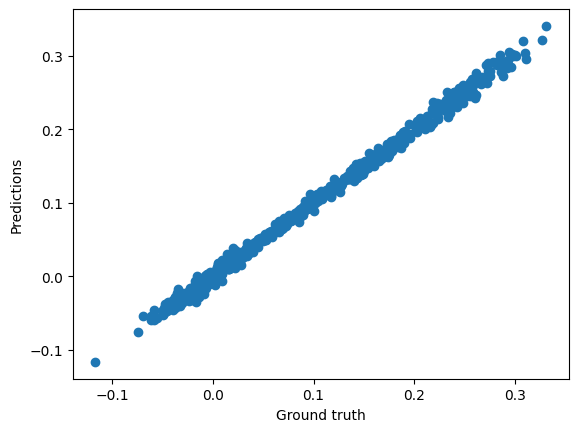

In [17]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict RL foot -> y

In [20]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_RL_swing[:, 0:1], # previous motion command
               X_footsteps_accelerations_absolute_RL_swing[:, 3:4], # current motion command
               X_footsteps_accelerations_absolute_RL_swing[:, -5:-4], # previous CoM velocity
               X_footsteps_accelerations_absolute_RL_swing[:, 10:12], # FL (x,y) position
               X_footsteps_accelerations_absolute_RL_swing[:, 13:15], # FR (x,y) position
               X_footsteps_accelerations_absolute_RL_swing[:, 16:18], # RL (x,y) position
               X_footsteps_accelerations_absolute_RL_swing[:, 19:21])) # RR (x,y) position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_RL_swing[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_rl_relative_swinging_y = find_best_model(X, Y, runs=5000)

R2:  0.9420815477784995
RMSE:  0.005721691192595607
The lowest error is:  4.051638298252502e-06
The highest error is:  0.022293052612927966
The avg. error is:  0.004177473777190503


In [21]:
model_rl_relative_swinging_y.coef_

array([[-0.00448785,  0.00874132, -0.02099453, -0.4986127 ,  0.32428166,
        -0.31793652, -1.08107051,  0.32000619,  0.01706234,  0.53886317,
         0.25088465]])

In [22]:
model_rl_relative_swinging_y.intercept_

array([0.26673828])

Text(0, 0.5, 'Predictions')

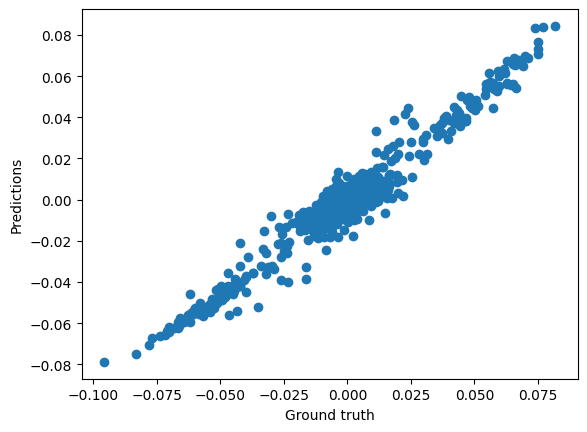

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')